# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

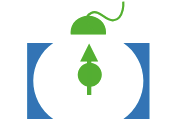

In [2]:
# initial state is a thermal state
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [4]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [5]:
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation

measure = {
    "gate": povm_measure_operator,
    "initial_params": jax.random.uniform(
        key=jax.random.PRNGKey(42), shape=(1, 2), minval=0.0, maxval=jnp.pi
    )[0].tolist(),
    "measurement_flag": True,
    # "param_constraints": [
    #     [0, jnp.pi],
    #     [-2 * jnp.pi, 2 * jnp.pi],
    # ],  # if this is commented and no bouds the avg purity would be 0.91 and highest purity of a measurement sequence is 0.997
}

system_params = [measure]

result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=None,
    system_params=system_params,
    num_time_steps=5,
    mode="lookup",
    goal="purity",
    max_iter=1000,
    convergence_threshold=1e-20,
    learning_rate=0.01,
    evo_type="density",
    batch_size=10,
    eval_batch_size=64
)

In [6]:
result

FgResult(optimized_trainable_parameters={'initial_params': [Array([1.05297151, 0.07352308], dtype=float64)], 'lookup_table': [[Array([1.56022894, 0.07388012], dtype=float64), Array([1.11495276, 0.03728731], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0.

In [7]:
print(result.final_fidelity)

None


In [8]:
print(result.final_state)

[[[ 1.54806924e-04+0.j  3.09336066e-04+0.j  3.04509774e-04+0.j ...
   -2.80791675e-05+0.j -4.30235766e-05+0.j -3.12636065e-05+0.j]
  [ 3.09336066e-04+0.j  2.25572683e-03+0.j  3.55977436e-04+0.j ...
   -2.87813501e-05+0.j  1.76018605e-05+0.j -4.08796837e-05+0.j]
  [ 3.04509774e-04+0.j  3.55977436e-04+0.j  8.12175029e-04+0.j ...
   -6.06594978e-05+0.j -1.15382939e-04+0.j -5.44897671e-05+0.j]
  ...
  [-2.80791675e-05+0.j -2.87813501e-05+0.j -6.06594978e-05+0.j ...
    5.59208032e-06+0.j  9.84695253e-06+0.j  5.97212245e-06+0.j]
  [-4.30235766e-05+0.j  1.76018605e-05+0.j -1.15382939e-04+0.j ...
    9.84695253e-06+0.j  2.38167978e-05+0.j  8.64156784e-06+0.j]
  [-3.12636065e-05+0.j -4.08796837e-05+0.j -5.44897671e-05+0.j ...
    5.97212245e-06+0.j  8.64156784e-06+0.j  7.80675943e-06+0.j]]

 [[ 9.95448185e-01+0.j -9.73739684e-03+0.j -4.55228273e-03+0.j ...
   -1.53175342e-04+0.j  4.82752454e-05+0.j -5.23840226e-04+0.j]
  [-9.73739684e-03+0.j  9.70812232e-05+0.j  4.51993482e-05+0.j ...
    1.43

In [9]:
result.optimized_trainable_parameters['lookup_table']

[[Array([1.56022894, 0.07388012], dtype=float64),
  Array([1.11495276, 0.03728731], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.]

In [10]:
# 0.9163363647226792
print(result.final_purity)

0.9251428001875578


In [11]:
from feedback_grape.utils.purity import purity

# the highest purity can be 0.995 if the initial params that initializes the lookup table
# are between 0 and pi rather than -pi and pi
print("initial purity:", purity(rho=rho_cav))
for i, state in enumerate(result.final_state):
    print(f"Purity of state {i}:", purity(rho=state))

initial purity: 0.20000208604889932
Purity of state 0: 0.9929850865960047
Purity of state 1: 0.9912625349139808
Purity of state 2: 0.9827059473529275
Purity of state 3: 0.6203510241040638
Purity of state 4: 0.9827059473529275
Purity of state 5: 0.8252355569116118
Purity of state 6: 0.9912625349139808
Purity of state 7: 0.9827059473529275
Purity of state 8: 0.9282047975295309
Purity of state 9: 0.8973385831739333
Purity of state 10: 0.9679924664796657
Purity of state 11: 0.9912625349139808
Purity of state 12: 0.9929850865960047
Purity of state 13: 0.8623097993838454
Purity of state 14: 0.9929850865960047
Purity of state 15: 0.9929566938281851
Purity of state 16: 0.9679924664796657
Purity of state 17: 0.9912625349139808
Purity of state 18: 0.8253739298877365
Purity of state 19: 0.8252355569116118
Purity of state 20: 0.8794567789436464
Purity of state 21: 0.9912625349139808
Purity of state 22: 0.9912625349139808
Purity of state 23: 0.8973385831739333
Purity of state 24: 0.9282047975295309

In [12]:
result.returned_params

[[Array([[1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151, 0.07352308],
         [1.05297151

In [13]:
print(jax.random.PRNGKey(9))
time_step_keys = jax.random.split(jax.random.PRNGKey(9), 5)
print(time_step_keys)
for key in time_step_keys:
    print(jax.random.uniform(key))

[0 9]
[[2822284597 2722679661]
 [ 143080583 4281670255]
 [2676565412 4109519897]
 [1877436067 1979300842]
 [3339921199 4267639851]]
0.16232149317805766
0.07829857808883056
0.8422083576204116
0.23698051656885277
0.33005660981143814


In [14]:
from feedback_grape.fgrape import povm
import random

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))
param_constraints = measure['param_constraints']


rand_num = random.randint(1, 50)

time_step_keys = jax.random.split(jax.random.PRNGKey(rand_num), time_steps)
for i in range(time_steps):
    params = result.returned_params[i][0]
    print(f"params for time step {i}:", params[0])
    rho, _, _ = povm(
        rho,
        povm_measure_operator,
        params[0],
        gate_param_constraints=param_constraints,
        rng_key=time_step_keys[i],
    )
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.20000208604889932


KeyError: 'param_constraints'

In [ ]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.0973540364721641
0.9026459635278362


### Check stash for replacement of dict implementation

In [ ]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 2.15088985e-01+0.j -1.31497208e-01+0.j  5.60463671e-03+0.j
   4.72126607e-03+0.j  1.07176216e-02+0.j -5.79642213e-03+0.j
  -1.68179628e-02+0.j -3.38770126e-02+0.j  2.81968537e-03+0.j
   6.97125322e-03+0.j -6.38086983e-05+0.j  1.68042891e-02+0.j
  -1.89673710e-02+0.j -2.10047165e-02+0.j  1.31916307e-03+0.j
   9.95793648e-03+0.j  7.29660894e-03+0.j  1.69340297e-03+0.j
  -1.39066431e-02+0.j -9.44072090e-03+0.j -6.19862640e-03+0.j
   9.38643364e-03+0.j  4.27352512e-03+0.j  6.74391505e-04+0.j
  -6.81554073e-03+0.j -1.71909436e-04+0.j -2.91743856e-03+0.j
  -1.97330149e-04+0.j -7.22428959e-04+0.j -4.91382372e-03+0.j]
 [-1.31497208e-01+0.j  2.61336413e-01+0.j  3.72789480e-02+0.j
  -3.60852572e-02+0.j -1.09681585e-02+0.j  2.05981739e-02+0.j
  -8.35070073e-03+0.j  3.19560138e-02+0.j -3.28286758e-02+0.j
  -2.05732362e-02+0.j -1.17765426e-02+0.j -2.46523536e-02+0.j
   4.41363118e-03+0.j  9.56697443e-04+0.j -9.75468731e-03+0.j
  -1.17081608e-02+0.j -1

In [ ]:
print("Final state from solver:", result.final_state)

Final state from solver: [[[ 1.80699430e-01+0.j  1.42973030e-01+0.j -1.67754690e-02+0.j ...
   -1.02536263e-03+0.j  1.82663620e-04+0.j -1.38263288e-04+0.j]
  [ 1.42973030e-01+0.j  1.33099699e-01+0.j -1.39007719e-02+0.j ...
   -1.28072581e-03+0.j  1.31599035e-03+0.j  6.18120953e-04+0.j]
  [-1.67754690e-02+0.j -1.39007719e-02+0.j  3.09285534e-02+0.j ...
   -3.88487878e-04+0.j -1.61607193e-03+0.j -1.18120209e-03+0.j]
  ...
  [-1.02536263e-03+0.j -1.28072581e-03+0.j -3.88487878e-04+0.j ...
    2.41525687e-04+0.j  1.67901314e-04+0.j  2.09124469e-04+0.j]
  [ 1.82663620e-04+0.j  1.31599035e-03+0.j -1.61607193e-03+0.j ...
    1.67901314e-04+0.j  4.06421382e-04+0.j  3.66445498e-04+0.j]
  [-1.38263288e-04+0.j  6.18120953e-04+0.j -1.18120209e-03+0.j ...
    2.09124469e-04+0.j  3.66445498e-04+0.j  3.54021959e-04+0.j]]

 [[ 7.13650918e-01+0.j -8.64550601e-02+0.j -1.13823737e-03+0.j ...
    1.10835052e-01+0.j  6.09789138e-02+0.j  7.22770633e-02+0.j]
  [-8.64550601e-02+0.j  1.52644245e-02+0.j -6.5036

In [ ]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     evo_type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [ ]:
import jax.numpy as jnp
import jax

initial_params = {
    "POVM": [0.1, 0.2],
    "test": [0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1],
}


# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [ ]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]


In [ ]:
jnp.array([0.1, 0.2, 0.2])

Array([0.1, 0.2, 0.2], dtype=float64)

In [ ]:
batch_size = 2

In [ ]:
rho_final_batched = jnp.repeat(jnp.expand_dims(rho_cav, 0), batch_size, axis=0)

In [ ]:
rho_final_batched.shape

(2, 30, 30)

In [ ]:
parent_key = jax.random.PRNGKey(0)
print(parent_key.shape)
rng_keys = jax.random.split(parent_key)

(2,)


In [ ]:
rng_keys[0].shape

(2,)

In [ ]:
print(jnp.array([1, 3]) * -jnp.array([2, 2]))

[-2 -6]


In [ ]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [ ]:
initial_params = {
    "qubit_unitary": [0.1, 0.1],
    "qubit_cavity_unitary": [0.2, 0.2],
}
param_constraints = [[[0, 0.5], [0.5, 1.0]], [[1.0, 1.5], [1.5, 2.0]]]

In [ ]:
def construct_ragged_row(
    num_of_rows, num_of_columns, param_constraints, rng_key
):
    res = []
    for i in range(num_of_rows):
        row = []
        for j in range(num_of_columns):
            rng_key, subkey = jax.random.split(rng_key)
            val = jax.random.uniform(
                subkey,
                shape=(),
                minval=param_constraints[j][0],
                maxval=param_constraints[j][1],
            )
            row.append(val)
        res.append(jnp.array(row))
    return res

In [ ]:
h_initial_state = None
rnn_model = None
# step 1: initialize the parameters
num_of_columns = 4
num_of_sub_lists = 1 * 5
F = []
param_constraints_reshaped = jnp.array(param_constraints).reshape(-1, 2)
# construct ragged lookup table
row_key = jax.random.PRNGKey(0)
for i in range(1, num_of_sub_lists + 1):
    row_key, _ = jax.random.split(row_key)
    F.append(
        construct_ragged_row(
            num_of_rows=2**i,
            num_of_columns=num_of_columns,
            param_constraints=param_constraints_reshaped,
            rng_key=row_key,
        )
    )
# step 2: pad the arrays to have the same number of rows
min_num_of_rows = 2 ** len(F)
for i in range(len(F)):
    if len(F[i]) < min_num_of_rows:
        zeros_arrays = [
            jnp.zeros((num_of_columns,), dtype=jnp.float64)
            for _ in range(min_num_of_rows - len(F[i]))
        ]
        F[i] = F[i] + zeros_arrays

F

[[Array([0.33559649, 0.67583317, 1.07987065, 1.98053433], dtype=float64),
  Array([0.11240873, 0.64456978, 1.07282654, 1.92680755], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0.,

In [ ]:
def construct_ragged_row(
    num_of_rows, num_of_columns, param_constraints, rng_key
):
    res = []
    for i in range(num_of_rows):
        print(param_constraints[0][0])
        flattened = jax.random.uniform(
            rng_key,
            shape=(num_of_columns,),
            minval=param_constraints[i][0],
            maxval=param_constraints[i][1],
            dtype=jnp.float64,
        )
        res.append(flattened)
    return res

In [ ]:
param_constraints = ([[0, 0.5]],)